In order to execute this notebook, go to the menu bar and click **Run**/**Run all cells**. You can also run individual cells by selecting the cell (a blue bar will appear to the left of the active cell, then pressing `Shift+Enter`.

> **NOTE** Before running this notebook, you must install the external dependencies.
> To to this, uncomment the following cell by removing the leading `#` character, execute the cell,
> then put the `#` character back to prevent it from running again, thereby "commenting it out". Once everything is installed you may
> re-run the commented-out cell to hide the text generated by the installation.

In [1]:
# !pip install -Ur requirements.txt

In [2]:
# Linear algebra library
import numpy as np
# Plotting library
import matplotlib.pyplot as plt
# The next two lines set reasonable plot style defaults
# import scienceplots
# plt.style.use('science')

In [3]:
## Configure units
# Units are based on inch-kip-seconds
import opensees.units.iks as units
pi   = units.pi;
ft   = units.ft;
ksi  = units.ksi;
inch = units.inch;

In [4]:
## Distributed Inelasticity 2d Beam-Column Element 
#  fiber section

Set up basic model geometry

In [5]:
# import the openseespy interface which contains the "Model" class
import opensees.openseespy as ops

In [6]:
# generate Model data structure
model = ops.Model(ndm=2, ndf=3)

# Length of cantilever column
L = 8*ft;
# specify node coordinates
model.node(1,  0,   0 );  # first node
model.node(2,  0,   L );  # second node

# boundary conditions
model.fix(1, 1, 1, 1 )

## specify mass
model.mass(2, 2.0, 1e-8, 1e-8)

In [7]:
## Element name: 2d nonlinear frame element with distributed inelasticity

# Create material and add to Model
mat_tag = 1      # identifier that will be assigned to the new material
E    = 29000*ksi
fy   =    60*ksi
Hkin =     0
Hiso =     0
model.uniaxialMaterial("Steel01", mat_tag, fy, E, 0.01)
# model.uniaxialMaterial("ElasticPP", mat_tag, E, fy/E)
# model.uniaxialMaterial("UniaxialJ2Plasticity", mat_tag, E, fy, Hkin, Hiso)

#### Create a section

In [8]:
import opensees.section

# Load cross section geometry and add to Model
sec_tag = 1          # identifier that will be assigned to the new section
SecData = {}
SecData["nft"] = 4   # no of layers in flange
SecData["nwl"] = 8   # no of layers in web
SecData["IntTyp"] = "Midpoint";
SecData["FlgOpt"] = True
section = opensees.section.from_aisc("Fiber", "W24x131", # "W14x426", 
                                     sec_tag, tag=mat_tag, mesh=SecData, ndm=2, 
                                     units=units)
print(section)

SectionGeometry
    area: 38.42890000000003
    ixc:  4013.509824163335
    iyc:  343.8869259102087



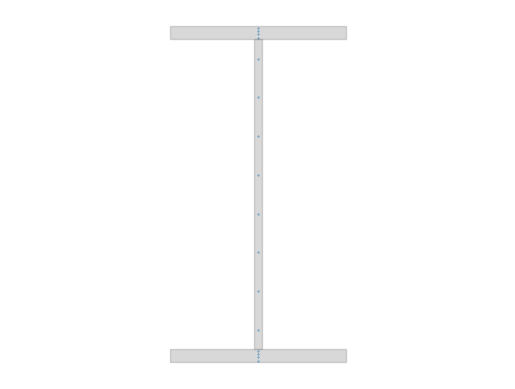

In [9]:
import sees.section
sees.section.render(section);

Printing the fiber section will display the effective
cross-sectional properties which result from quadrature over the cross section fibers:

In [10]:
print(section)

SectionGeometry
    area: 38.42890000000003
    ixc:  4013.509824163335
    iyc:  343.8869259102087



#### Create an element

In [11]:
cmd = opensees.tcl.dumps(section, skip_int_refs=True)
model.eval(cmd)

# Create element integration scheme
nIP = 4
int_tag = 1
model.beamIntegration("Lobatto", int_tag, sec_tag, nIP)

# Create element geometric transformation
model.geomTransf("Linear", 1)

# Finally, create the element
#                                    CONN   Geom    Int
model.element("ForceBeamColumn", 1, (1, 2),  1,   int_tag)

### Analysis

#### Eigenvalue Analysis

In [12]:
# State = Initialize_State (Model,ElemData)
# State = Structure('stif',Model,ElemData,State)

# Initialize the analysis state for transient analysis
model.analysis("Transient")

# Form stiffness and mass matrices
Kf = model.getTangent(k=1.0)  # free DOF stiffness matrix Kf for initial State
Mf = model.getTangent(m=1.0)  # free DOF mass matrix Ml

print("Kf:", Kf, sep="\n")
print("Mf:", Mf, sep="\n")

Kf:
[[ 1.57505061e+03  2.10362908e-30  7.56024291e+04]
 [-2.10362908e-30  1.16087302e+04 -1.21265960e-12]
 [ 7.56024291e+04 -1.21265960e-12  4.83855547e+06]]
Mf:
[[2.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-08 0.e+00]
 [0.e+00 0.e+00 1.e-08]]


Solve dynamic eigenvalue problem with `scipy` function `eig`

In [13]:
import scipy.linalg

omega,Ueig = scipy.linalg.eig(Kf,Mf)

# echo eigenmode periods
print(' The three lowest eigenmode periods are')
T = 2*pi/np.sqrt(omega)
print(T)

 The three lowest eigenmode periods are
[4.47793313e-01+0.j 2.85641961e-07+0.j 5.83159707e-06+0.j]


In general the `eigen` function should be used, which
takes advantage of sparsity in the system

In [14]:
for w in model.eigen(2):
    print(2*pi/np.sqrt(w))

0.44779331340120765
5.831597073594038e-06


#### Configure ground motion

In [15]:
# Apply damping in the first mode
zeta  = 0.02
model.modalDamping(zeta)

# alphaM, betaK = 0.01, 0.01
# model.rayleigh(alphaM, betaK, 0, 0)
# State = Add_Damping2State('Modal',Model,State,zeta)

In [16]:
# Deltat = 0.02
# AccHst = np.loadtxt("tabasFN.txt")

import quakeio
Event = quakeio.read("TAK000.AT2")
AccHst = Event.data
Deltat = Event["time_step"]["time_step"]

In [17]:
AccHst*units.gravity

array([-0.48646891, -0.48627123, -0.4833524 , ...,  0.14422188,
        0.1482186 ,  0.15219315])

In [18]:
load_tag = 1
model.timeSeries('Path', load_tag, dt=Deltat, factor=1.0, 
                         values=units.gravity*AccHst)

model.pattern('UniformExcitation', 1, 1, accel=load_tag)

#### Configure integration method

In [19]:
## initialize data for solution strategy
#                           gam  bet
model.integrator("Newmark", 1/2, 1/4, form="d")

#### Perform integration

In [20]:
nt   = len(AccHst)
Uplt = np.zeros(nt)
Vplt = np.zeros(nt)
Aplt = np.zeros(nt)
Pplt = np.zeros(nt)

# Defo = zeros(np,1)
# Forc = zeros(np,1)
for k in range(nt):
    if model.analyze(1, Deltat) != 0:
        print("Analysis failed")
        break
    # extract values for plotting from response history
    Uplt[k] = model.nodeDisp (2, 1)
    Vplt[k] = model.nodeVel  (2, 1)
    Aplt[k] = model.nodeAccel(2, 1)
#       Pplt[k] = Post[k].Pr[Pdof,:];
    # Defo(k) = Post(k).Elem{1}.v;
    # Forc(k) = Post(k).Elem{1}.q;

## Post-processing

#### Displacement History

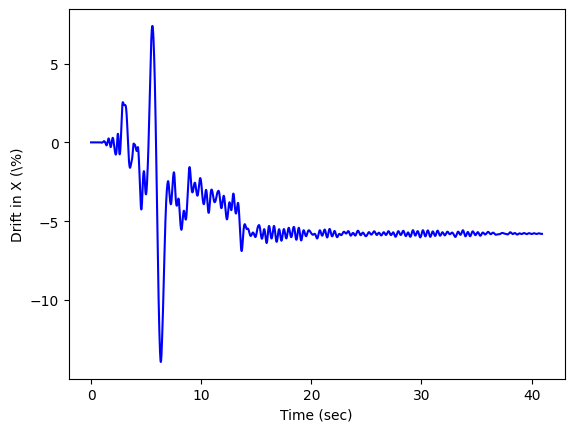

In [21]:
t  = np.arange(nt)*Deltat;

Xp = t
Yp = (Uplt/L)*100

FigHndl, AxHndl = plt.subplots()
AxHndl.set_xlabel('Time (sec)')
AxHndl.set_ylabel('Drift in X (\\%)')

AxHndl.plot(Xp,Yp,'b')
FigHndl.savefig("drift.png")

### Shear force-displacement history

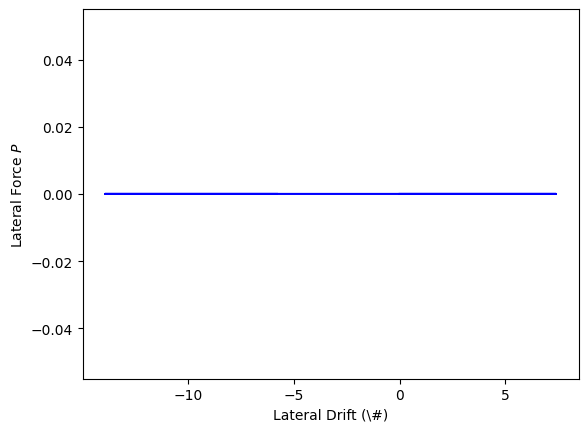

In [22]:
Xp = (Uplt/L)*100
Yp = Pplt

FigHndl, AxHndl = plt.subplots()
AxHndl.set_xlabel('Lateral Drift (\#)')
AxHndl.set_ylabel('Lateral Force $P$')

AxHndl.plot(Xp, Yp, 'b')
plt.show()